### Finding Correlations between Returns of Different Time Frames ###

A workbook to backtest and explore the relationship between various lookback and holding periods for time series data 

In the first part of the workbook, I explore the correlation coefficient and p-value of various lookback and holding period combinations. After some exploratory analysis, I build out a back test using results obtained from analysis (optimal CC and pval) 

In the second part of the workbook, I create some function to backtest the strategy with different parameters. I also create an iteration tool to iterate over many differnet lookback and holding period combinations which stores the results and performance statistics into a dataframe 

In the final part of the workbook, I test the strategy and the function on some daily asx stock data.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr

# import data and cleanse 
df=pd.read_csv('inputDataOHLCDaily_TU_20120511.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

In [58]:
# using various lookback and holding period values, explore the correlation between the two
# scipy.stats pearsonr function to calculate correlation coef (cc) and p-val
for lookback in [1, 5, 10, 25, 60, 120, 250]:
    for holddays in [1, 5, 10, 25, 60, 120, 250]:
        ret_lag=df.pct_change(periods=lookback)
        ret_fut=df.shift(-holddays).pct_change(periods=holddays)
        if (lookback >= holddays):
            indepSet=range(0, ret_lag.shape[0], holddays)
        else:
            indepSet=range(0, ret_lag.shape[0], lookback)
            
        ret_lag=ret_lag.iloc[indepSet]
        ret_fut=ret_fut.iloc[indepSet]
        goodDates=(ret_lag.notna() & ret_fut.notna())
        t1 = ret_lag[goodDates].dropna()
        t2 = ret_fut[goodDates].dropna()
        t1= np.array(t1['Close'])
        t2= np.array(t2['Close'])
        (cc, pval)=pearsonr(t1, t2)
        print('%4i %4i %7.4f %7.4f' % (lookback, holddays, cc, pval))
    

   1    1 -0.0576  0.0100
   1    5 -0.0769  0.0006
   1   10 -0.0274  0.2226
   1   25 -0.0139  0.5369
   1   60  0.0325  0.1529
   1  120  0.0205  0.3735
   1  250  0.0383  0.1089
   5    1 -0.0755  0.0007
   5    5 -0.1271  0.0111
   5   10 -0.0471  0.3485
   5   25  0.0323  0.5221
   5   60  0.0860  0.0907
   5  120  0.0543  0.2933
   5  250  0.0988  0.0649
  10    1 -0.0280  0.2118
  10    5 -0.0485  0.3348
  10   10  0.0367  0.6072
  10   25  0.1160  0.1045
  10   60  0.1800  0.0120
  10  120  0.0967  0.1870
  10  250  0.1687  0.0256
  25    1 -0.0140  0.5352
  25    5  0.0319  0.5272
  25   10  0.1511  0.0340
  25   25  0.1955  0.0843
  25   60  0.2372  0.0378
  25  120  0.1755  0.1320
  25  250  0.2482  0.0383
  60    1  0.0313  0.1685
  60    5  0.0799  0.1160
  60   10  0.1720  0.0165
  60   25  0.1848  0.1076
  60   60  0.2188  0.2213
  60  120  0.0000  0.9999
  60  250  0.3080  0.1040
 120    1  0.0222  0.3352
 120    5  0.0567  0.2731
 120   10  0.0960  0.1902
 120   25  0

APR=0.014601 Sharpe=0.858857
Max DD=-0.115294 Max DDD in days=615


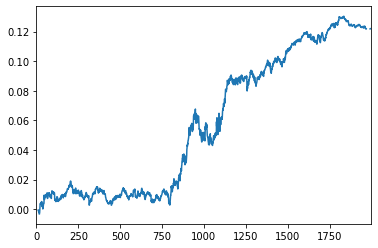

In [113]:
# Backtest using reults obtained above 
lookback=10
holddays=60

longs=df > df.shift(lookback)
shorts=df < df.shift(lookback)

pos=np.zeros(df.shape)

for h in range(holddays-1):
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# from calculateMaxDD import calculateMaxDD
# maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
# print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))

In [114]:
# Create functions to handle backtesting of the strategy to allow multiple iterations with ease 
# 1 with visualisations and one without for iterations tool 


def lookback_holddays_mom(df, lookback, holddays):
    longs=df > df.shift(lookback)
    shorts=df < df.shift(lookback)

    pos=np.zeros(df.shape)

    for h in range(holddays-1):
        long_lag=longs.shift(h).fillna(False)
        short_lag=shorts.shift(h).fillna(False)
        pos[long_lag]=pos[long_lag]+1
        pos[short_lag]=pos[short_lag]-1

    pos=pd.DataFrame(pos)
    pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
    ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
    cumret=(np.cumprod(1+ret)-1)

    APR, Sharpe = (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret))
    return APR, Sharpe

def lookback_holddays_mom_graph(df, lookback, holddays):
    longs=df > df.shift(lookback)
    shorts=df < df.shift(lookback)

    pos=np.zeros(df.shape)

    for h in range(holddays-1):
        long_lag=longs.shift(h).fillna(False)
        short_lag=shorts.shift(h).fillna(False)
        pos[long_lag]=pos[long_lag]+1
        pos[short_lag]=pos[short_lag]-1

    pos=pd.DataFrame(pos)
    pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
    ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
    cumret=(np.cumprod(1+ret)-1)
    cumret.plot()

    print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
#     from calculateMaxDD import calculateMaxDD
#     maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
#     print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
    

# using itertools product to create an iteration function to back test multiple strategies     
    
from itertools import product


def iter_TU_mom(df, arr_lookback, arr_holddays):
    
    results = pd.DataFrame()
    
    for lookback, holddays in product(arr_lookback, arr_holddays):
        APR, Sharpe = lookback_holddays_mom(df, lookback, holddays)
        results = results.append(pd.DataFrame(
            {'Lookback': lookback, 'HoldDays': holddays,
             'APR': APR,
             'Sharpe': Sharpe} ,index=[0]), ignore_index=True)
        
    return results

In [96]:
# Using new iteration tool on original dataset to backtest multiple strategies 
res = iter_TU_mom(df, [1, 5, 10, 25, 60, 120, 250], [1, 5, 10, 25, 60, 120, 250])
res

,Lookback,HoldDays,APR,Sharpe
0,1,1,0.000000,NaN
1,1,5,-0.004284,-0.358662
2,1,10,-0.001865,-0.105488
3,1,25,0.003389,0.218030
4,1,60,0.010226,0.619290
5,1,120,0.008827,0.519570
6,1,250,0.009357,0.546657
7,5,1,0.000000,NaN
8,5,5,0.000410,0.036554
9,5,10,0.007521,0.443071


APR=0.017266 Sharpe=1.126471
Max DD=-0.024847 Max DDD in days=339


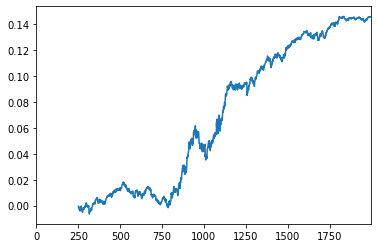

In [116]:
# visualisation of strategy with the highest sharpe ratio tested 
lookback_holddays_mom_graph(df, 250, 5)

In [110]:
# Import asx daiily data
# create a dataframe for CBA stock data 
asx_200 = pd.read_csv('ASX_200_daily.csv', index_col = 0, parse_dates =True)
cba = pd.DataFrame(asx_200['CBA']) 

# iterate over multiple strategies using CBA data 
res_cba = iter_TU_mom(cba, [2, 5, 10, 25, 60, 120, 250], [2, 5, 10, 25, 60, 120, 250])
res_cba

,Lookback,HoldDays,APR,Sharpe
0,2,2,-0.008128,0.080586
1,2,5,-0.097289,-0.509810
2,2,10,-0.084509,-0.270541
3,2,25,-0.108888,-0.427334
4,2,60,0.001133,0.122064
5,2,120,0.017099,0.191923
6,2,250,0.036728,0.274249
7,5,2,-0.084343,-0.262419
8,5,5,-0.158162,-0.738746
9,5,10,-0.073828,-0.213446


APR=0.025157 Sharpe=0.227909
Max DD=-0.433819 Max DDD in days=1247


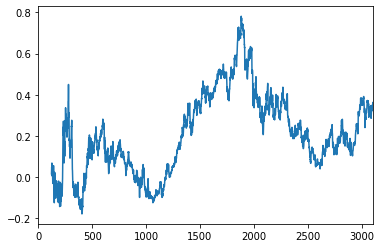

In [112]:
# Backtest and visualisation of best CBA strategy 
lookback_holddays_mom_graph(cba, 120, 120)